# Sebastian Petrik - Stranasum - Simple transformer abstractive summarization

Inspired by:
- https://www.kaggle.com/code/ashishsingh226/text-summarization-with-transformers
- https://www.tensorflow.org/text/tutorials/transformer


## Setup

In [1]:
!pip install --upgrade -q wandb --quiet
!pip install evaluate rouge_score --quiet

In [2]:
import os
print(os.environ.get('KAGGLE_CONTAINER_NAME')) # check if kaggle

kaggle_151J65sK68w7FfmTydC0sE87bsTqYa71banLd0a3gc-127459164-webtier


In [3]:
import pkg_resources
sorted(list(filter(
    lambda x: x[0] in ['numpy', 'pandas', 'tensorflow', 'tensorflow-text', 'keras', 'tensorflow-estimator', 'tensorflow-datasets', 'wandb', 'evaluate', 'rouge_score', 'gensim'],
    [(i.key, i.version) for i in pkg_resources.working_set]
)))

[('gensim', '4.0.1'),
 ('keras', '2.11.0'),
 ('numpy', '1.21.6'),
 ('pandas', '1.3.5'),
 ('tensorflow', '2.11.0'),
 ('tensorflow-datasets', '4.8.2'),
 ('tensorflow-estimator', '2.11.0'),
 ('tensorflow-text', '2.11.0'),
 ('wandb', '0.13.10')]

In [4]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import operator as op
import wandb
from wandb.keras import WandbCallback
from pprint import pprint
import evaluate
import gensim
import gensim.downloader
from tqdm import tqdm

## Configuration and Wandb

In [5]:
# Setup seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
CONFIG = dict(
    # Meta
    wandb_project = 'stranasum-dev',
    wandb_group = '-',
    host = 'kaggle',
    
    # Data
    dataset_name = "inshorts_10-70_3-16_v0.05_t0.05",
    val_split = 0.05,
    test_split = 0.05,
    
    # Sequences
    # - define lengths according to data
    max_input_length = 70, # Encoder sequence length, max article len, max token count in Encoder.
    max_target_length = 16, # Decoder sequence length, max summary len, max token count in Decoder.
    
    # Embeddings
    embedding_mode = 'normal', # normal, glove840b300d
    embeddings_trainable = False, # only for pretrained embeddings

    # Transformer hyperparameters
    num_layers = 3, # 4
    d_model = 128, # 128 -> embedding length ~ dimensions
    dff = 512, # 512
    num_heads = 8, # 8
    dropout_rate = 0.1, # 0.1

    # Training
    early_stopping_patience = 3, # patience - num of non-improving consecutive epochs
    max_epochs = 20, # 15
    batch_size = 256, # 256
    learning_rate_warmup_steps = 4000 # 4000
)

print("Config:")
pprint(CONFIG)

Config:
{'batch_size': 256,
 'd_model': 128,
 'dataset_name': 'inshorts_10-70_3-16_v0.05_t0.05',
 'dff': 512,
 'dropout_rate': 0.1,
 'early_stopping_patience': 3,
 'embedding_mode': 'normal',
 'embeddings_trainable': False,
 'host': 'kaggle',
 'learning_rate_warmup_steps': 4000,
 'max_epochs': 20,
 'max_input_length': 70,
 'max_target_length': 16,
 'num_heads': 8,
 'num_layers': 3,
 'test_split': 0.05,
 'val_split': 0.05,
 'wandb_group': '-',
 'wandb_project': 'stranasum-dev'}


In [7]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb.login(key=user_secrets.get_secret("wandb"))

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Data loading

- load data from preprocessing

In [8]:
# show available data
!ls ../input
!ls ../input/pmxy-stranasum-preprocessing

glove840b300dtxt  nlpword2vecembeddingspretrained  pmxy-stranasum-preprocessing
__notebook__.ipynb
__output__.json
__results__.html
__results___files
custom.css
inshorts_10-70_3-16_v0.05_t0.05_test.csv
inshorts_10-70_3-16_v0.05_t0.05_train.csv
inshorts_10-70_3-16_v0.05_t0.05_val.csv
inshorts_10-70_3-16_v0.1_t0.1_test.csv
inshorts_10-70_3-16_v0.1_t0.1_train.csv
inshorts_10-70_3-16_v0.1_t0.1_val.csv
xsum_10-150_3-40_v0.05_t0.05_test.csv
xsum_10-150_3-40_v0.05_t0.05_train.csv
xsum_10-150_3-40_v0.05_t0.05_val.csv
xsum_10-150_3-40_v0.1_t0.1_test.csv
xsum_10-150_3-40_v0.1_t0.1_train.csv
xsum_10-150_3-40_v0.1_t0.1_val.csv
xsum_10-300_3-40_v0.05_t0.05_test.csv
xsum_10-300_3-40_v0.05_t0.05_train.csv
xsum_10-300_3-40_v0.05_t0.05_val.csv
xsum_10-300_3-40_v0.1_t0.1_test.csv
xsum_10-300_3-40_v0.1_t0.1_train.csv
xsum_10-300_3-40_v0.1_t0.1_val.csv


In [9]:
dataset_dir = "../input/pmxy-stranasum-preprocessing"
df_train = pd.read_csv(f"{dataset_dir}/{CONFIG['dataset_name']}_train.csv")
df_val = pd.read_csv(f"{dataset_dir}/{CONFIG['dataset_name']}_val.csv")
df_test = pd.read_csv(f"{dataset_dir}/{CONFIG['dataset_name']}_test.csv")

print("Train:", df_train.shape)
print("Val:", df_val.shape)
print("Test:", df_test.shape)

Train: (49593, 5)
Val: (2748, 5)
Test: (2755, 5)


# Tokenization

In [10]:
# Custom tokenizer
class Tokenizer(tf.Module):
    
    def __init__(self, vectorization_dataset: tf.data.Dataset, max_length: int):
        super().__init__(name="Tokenizer")
        
        self.max_length = max_length
        
        # Create and fit vectorizer from dataset
        self.vectorizer = tf.keras.layers.TextVectorization(
            output_mode='int',
            output_sequence_length=self.max_length,
            standardize=None
        )
        self.vectorizer.adapt(vectorization_dataset.batch(1024))
        
        # conversions
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=self.vectorizer.get_vocabulary(),
            mask_token='', oov_token='[UNK]'
        )
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=self.vectorizer.get_vocabulary(),
            mask_token='', oov_token='[UNK]',
            invert=True
        )
        
        # attributes
        self.vocab_size = self.vectorizer.vocabulary_size()
        self.start_token = self.word_to_id('<sos>')
        self.end_token = self.word_to_id('<eos>')
        
        print(f"Tokenizer maxlen={self.max_length}, top vocabulary: {self.vectorizer.get_vocabulary()[:10]}")
        
        
    # to convert text to tokens, call vectorizer directly !
        
    # convert tokens back to text
    @tf.function
    def tokens_to_text(self, tokens):
        words = self.id_to_word(tokens)
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')
        result = tf.strings.regex_replace(result, '^ *<sos> *', '')
        result = tf.strings.regex_replace(result, ' *<eos> *$', '')
        result = tf.strings.regex_replace(result, '<dot>', '.')
        return result

# Setup tokenizers

input_tokenizer = Tokenizer(
    tf.data.Dataset.from_tensor_slices(df_train['article']),
    CONFIG['max_input_length']
)

target_tokenizer = Tokenizer(
    tf.data.Dataset.from_tensor_slices(df_train['summary']),
    CONFIG['max_target_length']
)

Tokenizer maxlen=70, top vocabulary: ['', '[UNK]', 'the', 'to', 'in', 'of', 'a', 'and', '<sos>', '<eos>']
Tokenizer maxlen=16, top vocabulary: ['', '[UNK]', '<sos>', '<eos>', 'to', 'in', 's', 'for', 'of', 'on']


In [11]:
# try out 
sample_tokens = input_tokenizer.vectorizer(tf.constant(['<sos> the dog ate the food <eos>']))
sample_tokens

<tf.Tensor: shape=(1, 70), dtype=int64, numpy=
array([[    8,     2,  1756, 10598,     2,   398,     9,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]])>

In [12]:
input_tokenizer.tokens_to_text(sample_tokens).numpy().astype('str') # binary string tensor into decoded string array

array(['the dog ate the food'], dtype='<U20')

In [13]:
target_tokenizer.vectorizer(tf.constant('<sos> a man was murdered <eos>'))

<tf.Tensor: shape=(16,), dtype=int64, numpy=
array([   2,   11,   35,   37, 2727,    3,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])>

In [14]:
def convert_to_tokenized_sequences(input_texts: np.array, target_texts: np.array):
    
    # convert numpy text arrays into vectors
    inputs = input_tokenizer.vectorizer(input_texts)
    targets = target_tokenizer.vectorizer(target_texts)
    
    # drop EOS token
    targets_inputs = targets[:,:-1]
    
    # drop SOS token, shifting sequence 1 step behind providing next word labels for each step
    targets_labels = targets[:,1:]
    
    return (inputs, targets_inputs), targets_labels

In [15]:
# Apply tokenization and create batched tf datasets ...

# convert to sequences and then into a tensorflow dataset
# shuffle - shuffle with buffer size = size of data for full uniform shuffle

dataset_train = tf.data.Dataset.from_tensor_slices(
    convert_to_tokenized_sequences(df_train['article'], df_train['summary'])
).shuffle(df_train.shape[0]).batch(CONFIG['batch_size'])

dataset_val = tf.data.Dataset.from_tensor_slices(
    convert_to_tokenized_sequences(df_val['article'], df_val['summary'])
).shuffle(df_val.shape[0]).batch(CONFIG['batch_size'])

# take 1 sample batch for further inspection (later)
for (sample_input, sample_target), sample_target_labels in dataset_train.take(1):
    break
    
print('Sample single batch from dataset:')

print(sample_input.shape)
print(sample_target.shape)
print(sample_target_labels.shape)

print(sample_target[0])
print(sample_target_labels[0])

Sample single batch from dataset:
(256, 70)
(256, 15)
(256, 15)
tf.Tensor(
[   2   57 2767 2718    8   21 2305    5 2535  911   25   86    3    0
    0], shape=(15,), dtype=int64)
tf.Tensor(
[  57 2767 2718    8   21 2305    5 2535  911   25   86    3    0    0
    0], shape=(15,), dtype=int64)


In [16]:
# try to get special token numbers so we can see them in prints
print(input_tokenizer.vectorizer(tf.constant('<sos> <eos> <unk> [UNK] <dot> <pad>')))
print(target_tokenizer.vectorizer(tf.constant('<sos> <eos> <unk> [UNK] <dot> <pad>')))

tf.Tensor(
[8 9 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(70,), dtype=int64)
tf.Tensor([2 3 1 1 1 1 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int64)


## Pretrained embeddings

In [17]:
# (Legacy)
# glove_vectors = gensim.downloader.load('glove-twitter-25')
# glove_vectors.most_similar('queen')
# glove_vectors.vectors.shape

In [18]:
def create_emb_matrix(tokenizer, embedding_vectors):
    hits = 0
    misses = 0
    embedding_dim = 300

    tokenizer_vocabulary = tokenizer.vectorizer.get_vocabulary()
    embedding_matrix = np.zeros((tokenizer.vocab_size, embedding_dim))

    for i in tqdm(range(tokenizer.vocab_size)):
        embedding_val = embedding_vectors.get(tokenizer_vocabulary[i])

        if embedding_val is not None:
            embedding_matrix[i] = embedding_val
            hits += 1
        else:
            misses += 1

    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix

In [19]:
input_emb_matrix = None
target_emb_matrix = None

if CONFIG['embedding_mode'] == 'glove840b300d':
    print("Setting up glove 840b 300d embeddings...")
    
    embedding_vectors = {}
    
    # load glove
    f = open('../input/glove840b300dtxt/glove.840B.300d.txt')
    for line in tqdm(f):
        value = line.split(' ')
        word = value[0]
        coef = np.array(value[1:],dtype = 'float32')
        embedding_vectors[word] = coef
        
    # create matrices for tokenizers
    input_emb_matrix = create_emb_matrix(input_tokenizer, embedding_vectors)
    target_emb_matrix = create_emb_matrix(target_tokenizer, embedding_vectors)

## Transformer model implementation

Positional encoding shape (2048, 512)


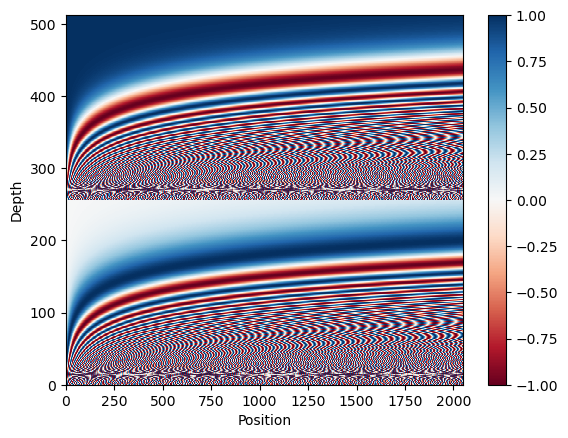

In [20]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

# We try out the encoding func
pos_encoding = positional_encoding(length=2048, depth=512)
print('Positional encoding shape', pos_encoding.shape) # Check the shape.

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [21]:
class TransformerEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, emb_matrix):
        super().__init__()
        self.d_model = d_model
        
        if emb_matrix == None:
            self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        else:
            self.embedding = tf.keras.layers.Embedding(
            vocab_size,
            d_model,
            weights=[emb_matrix],
            trainable=CONFIG['embeddings_trainable'],
            mask_zero=True
        )
        
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x 

# Try
# sample_emb_input = TransformerEmbedding(vocab_size=input_tokenizer.vocab_size, d_model=512)(sample_input)
# sample_emb_target = TransformerEmbedding(vocab_size=target_tokenizer.vocab_size, d_model=512)(sample_target)

# sample_emb_target._keras_mask

In [22]:
# base attention for further subclassing
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [23]:
class CrossAttention(BaseAttention):
    
    # x = target sequence, context = context sequence
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

# Try on sample
# sample_ca = CrossAttention(num_heads=2, key_dim=512)
# print(sample_emb_input.shape)
# print(sample_emb_target.shape)
# print(sample_ca(sample_emb_input, sample_emb_target).shape)

In [24]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

# Try
# sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)
# print(sample_emb_input.shape)
# print(sample_gsa(sample_emb_input).shape)

In [25]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x
    
# sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)
# print(sample_emb_target.shape)
# print(sample_csa(sample_emb_target).shape)

In [26]:
# test latter elements do not depend on earlier elements, making no difference
# if we remove the earlier elements before or after applying csa layer
# out1 = sample_csa(embed_target(sample_target[:, :3])) 
# out2 = sample_csa(embed_target(sample_target))[:, :3]
# tf.reduce_max(abs(out1 - out2)).numpy()

In [27]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

# Try
# sample_ffn = FeedForward(512, 2048)
# print(sample_emb_target.shape)
# print(sample_ffn(sample_emb_target).shape)

In [28]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x
    
# sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)
# print(sample_encoder_layer(sample_emb_input).shape)

In [29]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                   dff, vocab_size, dropout_rate=0.1):
        
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = TransformerEmbedding(
            vocab_size=vocab_size, d_model=d_model,
            emb_matrix=input_emb_matrix,
        )

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)
        ]
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch_size, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

# Try
# sample_encoder = Encoder(num_layers=4,
#                          d_model=512,
#                          num_heads=8,
#                          dff=2048,
#                          vocab_size=input_tokenizer.vocab_size)

# sample_encoder_output = sample_encoder(sample_input, training=False)

# print(sample_input.shape)
# print(sample_encoder_output.shape)

In [30]:
class DecoderLayer(tf.keras.layers.Layer):
    
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x
    
# sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)
# sample_decoder_layer_output = sample_decoder_layer(
#     x=sample_emb_target, context=sample_emb_input
# )

# print(sample_emb_input.shape)
# print(sample_emb_target.shape)
# print(sample_decoder_layer_output.shape)

In [31]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = TransformerEmbedding(vocab_size=vocab_size,
                                                 d_model=d_model,
                                                 emb_matrix=target_emb_matrix
                                                )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                         dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

# Try
# sample_decoder = Decoder(num_layers=4,
#                          d_model=512,
#                          num_heads=8,
#                          dff=2048,
#                          vocab_size=target_tokenizer.vocab_size)

# sample_decoder_output = sample_decoder(x=sample_target, context=sample_emb_input)

# print(sample_target.shape)
# print(sample_emb_input.shape)
# print(sample_decoder_output.shape)

In [32]:
# sample_decoder.last_attn_scores.shape

In [33]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
        
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context, x  = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits


In [34]:
# Construct transformer
transformer = Transformer(
    num_layers=CONFIG['num_layers'],
    d_model=CONFIG['d_model'],
    num_heads=CONFIG['num_heads'],
    dff=CONFIG['dff'],
    input_vocab_size=input_tokenizer.vocab_size,
    target_vocab_size=target_tokenizer.vocab_size,
    dropout_rate=CONFIG['dropout_rate']
)

In [35]:
input_tokenizer.vocab_size, target_tokenizer.vocab_size

(91909, 33023)

In [36]:
# Call transformer on sample input, this will build it and setup inputs

sample_transformer_output = transformer((sample_input, sample_target))
print(sample_input.shape)
print(sample_target.shape)
print(sample_transformer_output.shape)

(256, 70)
(256, 15)
(256, 15, 33023)


In [37]:
# sample_transformer_attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
# print(sample_transformer_attn_scores.shape) 

In [38]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  13743488  
                                                                 
 decoder (Decoder)           multiple                  7789312   
                                                                 
 dense_12 (Dense)            multiple                  4259967   
                                                                 
Total params: 25,792,767
Trainable params: 25,792,767
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 0, 'Train Step')

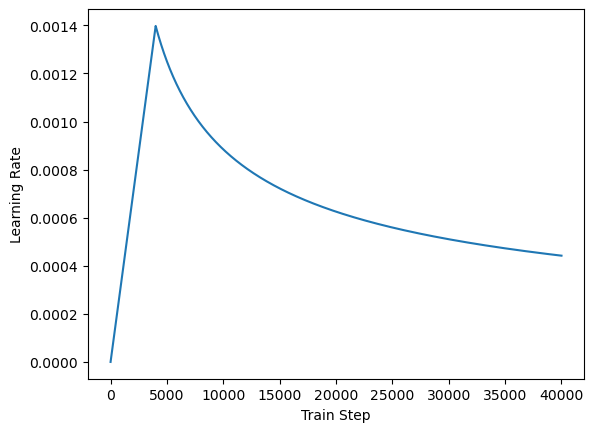

In [39]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
    def get_config(self):
        config = {
            'd_model': self.d_model,
            'warmup_steps': self.warmup_steps
        }
        return config
#         base_config = super(CustomSchedule, self).get_config()
#         return dict(list(base_config.items()) + list(config.items()))

learning_rate = CustomSchedule(CONFIG['d_model'], CONFIG['learning_rate_warmup_steps'])

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)


plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [40]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none'
    )
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)


# masked_loss(tf.constant([0.5], dtype=tf.float32), tf.constant([[0.5, 0.2]], dtype=tf.float32))

In [41]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy]
)

## Training

In [42]:
# Callbacks 
!mkdir -p checkpoints

modeldir = f"checkpoints"
checkpoint_filepath = modeldir + '/checkpoint.hdf'
print('Model checkpoint:', checkpoint_filepath)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min', verbose=1,
    patience=CONFIG['early_stopping_patience'],
    restore_best_weights=True # restore only best weights relative to val_loss
)

csv_logger=tf.keras.callbacks.CSVLogger(
    modeldir + '/log.csv', separator=",", append=True
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

try:
    model.load_weights(checkpoint_filepath)
    print('Loaded model weights checkpoint.')
except:
    print('Cannot load model weights from checkpoint, it may not exist yet.')

Model checkpoint: checkpoints/checkpoint.hdf
Cannot load model weights from checkpoint, it may not exist yet.


In [43]:
wandb_run = wandb.init(
    project=CONFIG['wandb_project'], 
    config=CONFIG,
    group=CONFIG['wandb_group'], 
)

wandb: Currently logged in as: plasmoxy (pmxy). Use `wandb login --relogin` to force relogin


In [44]:
%%time

# Training
    
history = transformer.fit(
    dataset_train,
    epochs=CONFIG['max_epochs'],
    validation_data=dataset_val,
    callbacks=[
        WandbCallback(save_model=False),
        early_stopping,
        csv_logger,
        model_checkpoint_callback
    ]
)

Epoch 1/20
194/194 [==============================] - 106s 422ms/step - loss: 10.0902 - masked_accuracy: 0.0852 - val_loss: 9.5641 - val_masked_accuracy: 0.1061
Epoch 2/20
194/194 [==============================] - 67s 345ms/step - loss: 8.8078 - masked_accuracy: 0.1055 - val_loss: 8.1286 - val_masked_accuracy: 0.1061
Epoch 3/20
194/194 [==============================] - 65s 332ms/step - loss: 7.7167 - masked_accuracy: 0.1061 - val_loss: 7.5154 - val_masked_accuracy: 0.1099
Epoch 4/20
194/194 [==============================] - 65s 332ms/step - loss: 7.2146 - masked_accuracy: 0.1342 - val_loss: 7.1131 - val_masked_accuracy: 0.1498
Epoch 5/20
194/194 [==============================] - 64s 329ms/step - loss: 6.7520 - masked_accuracy: 0.1643 - val_loss: 6.7467 - val_masked_accuracy: 0.1748
Epoch 6/20
194/194 [==============================] - 64s 330ms/step - loss: 6.2699 - masked_accuracy: 0.1932 - val_loss: 6.3758 - val_masked_accuracy: 0.2002
Epoch 7/20
194/194 [========================

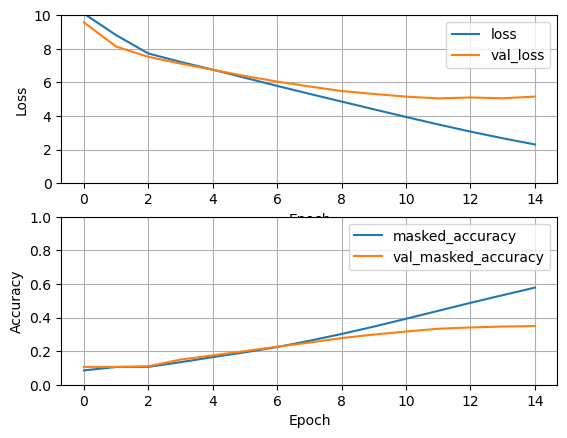

In [45]:
def plot_history(history):
    fig, (axl, axa) = plt.subplots(nrows=2, ncols=1)
    axl.plot(history.history['loss'], label='loss')
    axl.plot(history.history['val_loss'], label='val_loss')
    axl.set_ylim([0, 10])
    axl.set_xlabel('Epoch')
    axl.set_ylabel('Loss')
    axl.legend()
    axl.grid(True)
    
    axa.plot(history.history['masked_accuracy'], label='masked_accuracy')
    axa.plot(history.history['val_masked_accuracy'], label='val_masked_accuracy')
    axa.set_ylim([0, 1])
    axa.set_xlabel('Epoch')
    axa.set_ylabel('Accuracy')
    axa.legend()
    axa.grid(True)
    
    fig.show()
    
if history != None:
    plot_history(history)
else:
    print("No history to display.")

## Inference

In [46]:
# LEGACY - unoptimized inference using python array
class SummarizerSingleStep(tf.Module):
    def __init__(self, transformer, input_tokenizer, target_tokenizer):
        
        # todo
        self.transformer = transformer
        self.input_tokenizer = input_tokenizer
        self.target_tokenizer = target_tokenizer

    # expect sentence to be prepared with <sos> <eos> and clean
    # @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def __call__(self, sentence: str):

        encoder_input = tf.expand_dims(self.input_tokenizer.vectorizer(sentence), 0)

        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        # output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        # output_array = output_array.write(0, summary_start_token)
        
        summary_start_token = target_tokenizer.vectorizer('<sos>')[0].numpy()
        summary_end_token = target_tokenizer.vectorizer('<eos>')[0].numpy()
        
        decoder_input = [summary_start_token]
        output = tf.expand_dims(decoder_input, 0)

        for i in tf.range(self.target_tokenizer.max_length):
            
            predictions = self.transformer([encoder_input, output], training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

            # TODO: why cast needed here ??
            predicted_id = tf.cast(tf.argmax(predictions, axis=-1), dtype=tf.int32)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            # output_array = output_array.write(i+1, predicted_id[0])
            output = tf.concat([output, predicted_id], axis=-1)

            if predicted_id == summary_end_token:
                break
        
        
        prediction = tf.squeeze(output, axis=0)
        tokens = np.expand_dims(prediction.numpy(), 0)
        
        # print(tokens)
        
        # text = self.tokenization.summary_tokenizer.sequences_to_texts(tokens)[0]
        text = self.target_tokenizer.tokens_to_text(tokens)[0]

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer([encoder_input, output[:,:-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, tokens, attention_weights

# Optimized inference using tensorflow tensorarray
class Summarizer(tf.Module):
    def __init__(self, transformer, input_tokenizer, target_tokenizer):
        
        # todo
        self.transformer = transformer
        self.input_tokenizer = input_tokenizer
        self.target_tokenizer = target_tokenizer
        
    def to_tf(self, text: str):
        return tf.constant([text])
    
    def from_tf(self, tensor: tf.Tensor):
        return bytes.decode(tensor.numpy())

    # expect sentence to be prepared with <sos> <eos> and clean
    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def __call__(self, sentence: tf.Tensor):

        encoder_input = self.input_tokenizer.vectorizer(sentence)
        
        start_token = target_tokenizer.vectorizer(tf.constant('<sos>'))[0][tf.newaxis]
        end_token = target_tokenizer.vectorizer(tf.constant('<eos>'))[0][tf.newaxis]
        
        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start_token)
        output = tf.transpose(output_array.stack())

        for i in tf.range(self.target_tokenizer.max_length):
            
            output = tf.transpose(output_array.stack())
            
            predictions = self.transformer([encoder_input, output], training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

            # argmax
            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            # output_array = output_array.write(i+1, predicted_id[0])
            output_array = output_array.write(i+1, predicted_id[0])

            # stop on end
            if predicted_id == end_token:
                break
        
        output = tf.transpose(output_array.stack())
        
        # print(tokens)
        
        # text = self.tokenization.summary_tokenizer.sequences_to_texts(tokens)[0]
        text = self.target_tokenizer.tokens_to_text(output)[0]

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer([encoder_input, output[:,:-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, output, attention_weights


summarizer = Summarizer(transformer, input_tokenizer, target_tokenizer)

In [47]:
%%time
# (inference benchmark)

# summarizer_single = SummarizerSingleStep(transformer, input_tokenizer, target_tokenizer)
# df_train[:5]['article'].apply(lambda text: summarizer_single(text)[0])

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs


In [48]:
%%time

# df_train[:5]['article'].apply(lambda text: summarizer(summarizer.to_tf(text))[0])

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11 µs


In [49]:
def remove_special_tokens(text):
        text = text.lower()
        text = text.replace("<sos>", "").replace("<eos>", "")
        text = text.replace("<unk>", "##")
        text = text.replace("<dot>", ". ") # normal syntax with dot at end
        text = text.strip()
        return text

def remove_special_tokens_frame(frame: pd.DataFrame):
    frame['article'] = frame['article'].apply(remove_special_tokens)
    frame['summary'] = frame['summary'].apply(remove_special_tokens)
    frame['predicted'] = frame['predicted'].apply(remove_special_tokens)
    return frame
    
# Run summarization inference on entire frame
def summarize_frame(frame):
    
    frame = frame.copy()
    frame['predicted'] = '<NONE>'
    
    for i in range(0, frame.shape[0]):
        if i%25 == 0:
            print(f"Summarising ... {i}/{frame.shape[0]}")
            
        article = frame.iloc[i]['article']
        summary = frame.iloc[i]['summary']
        
        summarized_tf, summarized_tokens, attention_weights = summarizer(
            tf.constant([article])
        )
        
        summarized_text = summarizer.from_tf(summarized_tf)
        
        frame.iloc[i, frame.columns.get_loc('predicted')] = summarized_text
        
    return frame

def pretty_summaries(frame):
    
    for i, row in frame.iterrows():
        print(f"\n ------------------")
        print(f"Article  : {remove_special_tokens(row['article'])}")
        print(f"\nSummary  : {remove_special_tokens(row['summary'])}")
        print(f"\nPredicted: {remove_special_tokens(row['predicted'])}")
        print()
        print(f"------------------")

## Inference on test and val sets

In [50]:
%%time

# Predict on test set and save
print('--- Runing inference on test set ---\n')
test_pred = remove_special_tokens_frame(summarize_frame(df_test))
test_pred

--- Runing inference on test set ---

Summarising ... 0/2755
Summarising ... 25/2755
Summarising ... 50/2755
Summarising ... 75/2755
Summarising ... 100/2755
Summarising ... 125/2755
Summarising ... 150/2755
Summarising ... 175/2755
Summarising ... 200/2755
Summarising ... 225/2755
Summarising ... 250/2755
Summarising ... 275/2755
Summarising ... 300/2755
Summarising ... 325/2755
Summarising ... 350/2755
Summarising ... 375/2755
Summarising ... 400/2755
Summarising ... 425/2755
Summarising ... 450/2755
Summarising ... 475/2755
Summarising ... 500/2755
Summarising ... 525/2755
Summarising ... 550/2755
Summarising ... 575/2755
Summarising ... 600/2755
Summarising ... 625/2755
Summarising ... 650/2755
Summarising ... 675/2755
Summarising ... 700/2755
Summarising ... 725/2755
Summarising ... 750/2755
Summarising ... 775/2755
Summarising ... 800/2755
Summarising ... 825/2755
Summarising ... 850/2755
Summarising ... 875/2755
Summarising ... 900/2755
Summarising ... 925/2755
Summarising ... 9

,Unnamed: 0,article,summary,article_len_approx,summary_len_approx,predicted
0,22808,italian cardiologist dr valerio sanguigni has ...,doctor claims making ice-cream to enhance spor...,58,9,italian firm creates headphones in sports
1,3347,virgin group s billionaire founder richard bra...,richard branson launches new space company vir...,61,9,company launches new rocket launch for phone car
2,4276,wbo oriental champion china s zulpikar maimait...,wbo oriental champion refuses to fight vijende...,62,9,vijender s cube in china s next to fight on sept
3,49406,according to a report by the harvard kennedy s...,indian nuke assets face insider threats report,60,8,india using nuclear weapons that can t be treated
4,12359,filmmaker ashutosh gowariker will be deliverin...,ashutosh gowariker to deliver lecture at yashw...,55,10,bhuvneshwar kumar to be held in 2016
...,...,...,...,...,...,...
2750,32938,hurriyat leader syed ali geelani was detained ...,hurriyat leader geelani detained in srinagar,58,7,kashmiri leader detained for death
2751,31905,railway minister suresh prabhu on saturday sai...,railways to raise $5 billion to finance projects,61,9,railway ministry has been covered to fund for ...
2752,32134,actor sushant singh rajput is set to star in a...,sushant to star in space film chanda mama door ke,61,11,sushant to star in space propulsion system
2753,18835,cricketer yuvraj singh who visited the parliam...,yuvraj misspells pm modi s name in wedding inv...,62,10,yuvraj singh visits pm modi s wedding card for...


In [51]:
test_pred.to_csv('testset_evaluation_data.csv')
print('Saved test set evaluation data.')

Saved test set evaluation data.


In [52]:
%%time

# Predict on test set and save
print('--- Runing inference on validation set ---\n')
val_pred = remove_special_tokens_frame(summarize_frame(df_val))
val_pred

--- Runing inference on validation set ---

Summarising ... 0/2748
Summarising ... 25/2748
Summarising ... 50/2748
Summarising ... 75/2748
Summarising ... 100/2748
Summarising ... 125/2748
Summarising ... 150/2748
Summarising ... 175/2748
Summarising ... 200/2748
Summarising ... 225/2748
Summarising ... 250/2748
Summarising ... 275/2748
Summarising ... 300/2748
Summarising ... 325/2748
Summarising ... 350/2748
Summarising ... 375/2748
Summarising ... 400/2748
Summarising ... 425/2748
Summarising ... 450/2748
Summarising ... 475/2748
Summarising ... 500/2748
Summarising ... 525/2748
Summarising ... 550/2748
Summarising ... 575/2748
Summarising ... 600/2748
Summarising ... 625/2748
Summarising ... 650/2748
Summarising ... 675/2748
Summarising ... 700/2748
Summarising ... 725/2748
Summarising ... 750/2748
Summarising ... 775/2748
Summarising ... 800/2748
Summarising ... 825/2748
Summarising ... 850/2748
Summarising ... 875/2748
Summarising ... 900/2748
Summarising ... 925/2748
Summarising

,Unnamed: 0,article,summary,article_len_approx,summary_len_approx,predicted
0,45221,future investments in india and the country s ...,environment cess on diesel cars not good siam,62,9,india to be linked to 40% if they can be aucti...
1,24321,us presidential nominee donald trump gained on...,trump cuts hillary s lead in opinion polls,61,9,trump gains clinton for up polls reports
2,44016,an equalisation levy of 6% on cross border dig...,6% equalisation levy to take effect from june 1,59,10,on sale of india to be launched for online
3,54158,the government on friday raised ₹637 crore thr...,govt raises ₹637 cr via sale of 10% stake in eil,62,12,gold raises ₹5 crore to buy stake in india in ...
4,26296,thousands of kilometres of the new zealand coa...,giant jellyfish cover new zealand coastline,58,7,new zealand has world’s largest hypersonic isl...
...,...,...,...,...,...,...
2743,25100,google s ai platform deepmind has become capab...,google s deepmind ai can now learn without hum...,60,11,google unveils its ai that can t be made
2744,36209,the second test between india and west indies ...,chase s 137 helps wi draw 2nd test with india,62,11,india s 2nd test ton ends on day 3 vs bangladesh
2745,42124,music publisher kobalt has launched a new app ...,app shows singers money they make in real time,64,10,new app launches app for calling me shared today
2746,27608,japanese scientists have developed a fire alar...,japan developed a wasabi fire alarm for the deaf,55,10,japanese scientists develop fire that let us p...


In [53]:
val_pred.to_csv('validationset_evaluation_data.csv')
print('Saved validation set evaluation data.')

Saved validation set evaluation data.


In [54]:
print('--- Example 10 test set summaries ---\n')
pretty_summaries(test_pred[:10])

--- Example 10 test set summaries ---


 ------------------
Article  : italian cardiologist dr valerio sanguigni has claimed to have created an ice-cream that will improve performance in sports his patented ice-creams have been created by mixing natural ingredients rich in anti-oxidants with frozen gelato sanguigni has also tested the ice-creams on his students which reportedly showed an improvement in their performance while exercising and in vascular function

Summary  : doctor claims making ice-cream to enhance sports performance

Predicted: italian firm creates headphones in sports

------------------

 ------------------
Article  : virgin group s billionaire founder richard branson has launched virgin orbit a new company to launch small satellites into space using its launcherone orbital launch vehicle the launcherone is a boeing 747-400 airliner designed to hold a rocket under its wing it fires the rocket into space to deliver satellites for other companies working in the space a

In [55]:
print('--- Example 10 validation set summaries ---\n')
pretty_summaries(val_pred[:10])

--- Example 10 validation set summaries ---


 ------------------
Article  : future investments in india and the country s image as an investment destination will be adversely affected if the proposed 30% environment cess on diesel cars and suvs is implemented society of indian automobile manufacturers siam said this comes after the supreme court asked delhi police to pay a 30% environment cess on vehicles value as a pre-condition for their registration

Summary  : environment cess on diesel cars not good siam

Predicted: india to be linked to 40% if they can be auctioned

------------------

 ------------------
Article  : us presidential nominee donald trump gained on his rival hillary clinton among us voters cutting her lead nearly by half according to reuters/ipsos poll clinton now leads trump by 44% to 40% whereas earlier she was leading by 44% to 37% this comes after trump claimed the election system was rigged and called on voters to get out and vote

Summary  : trump cuts hillar

Custom example:

In [56]:
print(summarizer.from_tf(summarizer(tf.constant([
    '<sos> an 18 year old man joe mama has been killed in a tragic car accident in washington us the police have reported that a car has crashed with a lorry this evening on new york street the injured man has died on site <eos>'
]))[0]))

us man killed 30 injured in car accident


In [57]:
print(summarizer.from_tf(summarizer(tf.constant([
    '<sos> the us president joe biden has annouced that he will be coming to china in april to consult the chinese president xi jingping about the current nuclear threats <eos>'
]))[0]))

us prez to be part of china for china s china


## Evaluation

In [58]:

# note, will fail on empty seq
bleu = evaluate.load('bleu')
bleu_test = bleu.compute(references=test_pred['summary'], predictions=test_pred['predicted'])
bleu_val = bleu.compute(references=val_pred['summary'], predictions=val_pred['predicted'])

In [59]:
rouge = evaluate.load('rouge')
rouge_test = rouge.compute(references=test_pred['summary'], predictions=test_pred['predicted'])
rouge_val = rouge.compute(references=val_pred['summary'], predictions=val_pred['predicted'])

In [60]:
# Evaluate metrics after inference and save to unified frame, save to 

ev_metrics = {
    'loss_best': min(history.history['loss']),
    'masked_accuracy_best': max(history.history['masked_accuracy']),
    'val_loss_best': min(history.history['val_loss']),
    'val_masked_accuracy_best': max(history.history['val_masked_accuracy']),
    
    'test_rouge1': rouge_test['rouge1'],
    'test_rouge2': rouge_test['rouge2'],
    'test_rougeL': rouge_test['rougeL'],
    'test_rougeLsum': rouge_test['rougeLsum'],
    'test_bleu': bleu_test['bleu'],
    
    'val_rouge1': rouge_val['rouge1'],
    'val_rouge2': rouge_val['rouge2'],
    'val_rougeL': rouge_val['rougeL'],
    'val_rougeLsum': rouge_val['rougeLsum'],
    'val_bleu': bleu_val['bleu'],
}

pd.DataFrame(ev_metrics, index=[0]).to_csv('evaluation_metrics.csv')

print("Evaluation metrics: ");
pprint(ev_metrics)

Evaluation metrics: 
{'loss_best': 2.302554130554199,
 'masked_accuracy_best': 0.577930212020874,
 'test_bleu': 0.05966976872463604,
 'test_rouge1': 0.2938235309776529,
 'test_rouge2': 0.09667184267875309,
 'test_rougeL': 0.27050917934364827,
 'test_rougeLsum': 0.27069638734947843,
 'val_bleu': 0.05544722534775331,
 'val_loss_best': 5.043781280517578,
 'val_masked_accuracy_best': 0.34912997484207153,
 'val_rouge1': 0.2905970108758169,
 'val_rouge2': 0.0943009788457908,
 'val_rougeL': 0.2694030739887243,
 'val_rougeLsum': 0.26950649642397617}


In [61]:
# save to wandb metric summary
for metric in ev_metrics:
    wandb_run.summary[metric] = ev_metrics[metric]


# finish wandb run
wandb_run.finish()

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▇▆▅▅▅▄▄▃▃▂▂▂▁▁
masked_accuracy,▁▁▁▂▂▃▃▄▄▅▅▆▇▇█
val_loss,█▆▅▄▄▃▃▂▂▁▁▁▁▁▁
val_masked_accuracy,▁▁▁▂▃▄▄▅▆▇▇████
best_epoch,11
best_val_loss,5.04378
epoch,14
loss,2.30255
loss_best,2.30255
masked_accuracy,0.57793
